In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from utils.subspace_clustering_helper_funcs import *
from utils.ae_eval_and_vis import *
from utils.ae_torch_classes import *

In [2]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

# Load in Data

In [3]:
print("Loading")

# Kai's laptop
#data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\PCA_40D\\"
#model_dir_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\Embedding\\Autoencoders\\'
# BRC Desktop
data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"
model_dir_path = 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\'

emg_dir = "filtered_datasets\\EMG_PPD\\"
both_dir = "filtered_datasets\\Both_PPD\\"
both_pca40_dir = "Both_PCA40\\"

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']
metadata_cols_df = pd.read_pickle('D:\\Kai_MetaGestureClustering_24\\saved_datasets\\metadata_cols_df.pkl')

emg_training_users_df = pd.read_pickle(data_path+emg_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
emg_test_users_df = pd.read_pickle(data_path+emg_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

both_training_users_df = pd.read_pickle(data_path+both_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
both_test_users_df = pd.read_pickle(data_path+both_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

both_pca_training_users_df = pd.read_pickle(data_path+both_pca40_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
both_pca_test_users_df = pd.read_pickle(data_path+both_pca40_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

Loading


In [6]:
# Maximum number of components
max_clusters = 12
num_clusters_range = list(range(2, max_clusters+1))

# These are the same variable...
num_rows_per_gesture = 64
timesteps = 64
batch_size = 32

In [9]:
def create_data_loader(df, num_gestures, num_rows_per_gesture, num_features, batch_size, shuffle):
    X_3D = df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_features)
    X_3DTensor = torch.tensor(X_3D, dtype=torch.float32)
    dataset = GestureDatasetAE(X_3DTensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# CREATE THE TRAINING SET
num_gestures = len(emg_training_users_df ) // num_rows_per_gesture
num_features = emg_training_users_df .shape[1]
emg_train_loader = create_data_loader(emg_training_users_df , num_gestures, num_rows_per_gesture, num_features, batch_size, shuffle=True)
# CREATE THE TEST SET
num_features = emg_test_users_df .shape[1]
num_gestures = len(emg_test_users_df ) // num_rows_per_gesture
emg_test_loader = create_data_loader(emg_test_users_df , num_gestures, num_rows_per_gesture, num_features, batch_size, shuffle=False)

# CREATE THE TRAINING SET
num_gestures = len(both_training_users_df ) // num_rows_per_gesture
num_features = both_training_users_df .shape[1]
both_train_loader = create_data_loader(both_training_users_df , num_gestures, num_rows_per_gesture, num_features, batch_size, shuffle=True)
# CREATE THE TEST SET
num_features = both_test_users_df .shape[1]
num_gestures = len(both_test_users_df ) // num_rows_per_gesture
both_test_loader = create_data_loader(both_test_users_df , num_gestures, num_rows_per_gesture, num_features, batch_size, shuffle=False)

# CREATE THE TRAINING SET
num_gestures = len(both_pca_training_users_df ) // num_rows_per_gesture
num_features = both_pca_training_users_df .shape[1]
both_pca_train_loader = create_data_loader(both_pca_training_users_df , num_gestures, num_rows_per_gesture, num_features, batch_size, shuffle=True)
# CREATE THE TEST SET
num_features = both_pca_test_users_df .shape[1]
num_gestures = len(both_pca_test_users_df ) // num_rows_per_gesture
both_pca_test_loader = create_data_loader(both_pca_test_users_df , num_gestures, num_rows_per_gesture, num_features, batch_size, shuffle=False)


## Load in and set up all saved models

Average testing loss across the entire test_loader: 0.26212913915514946
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


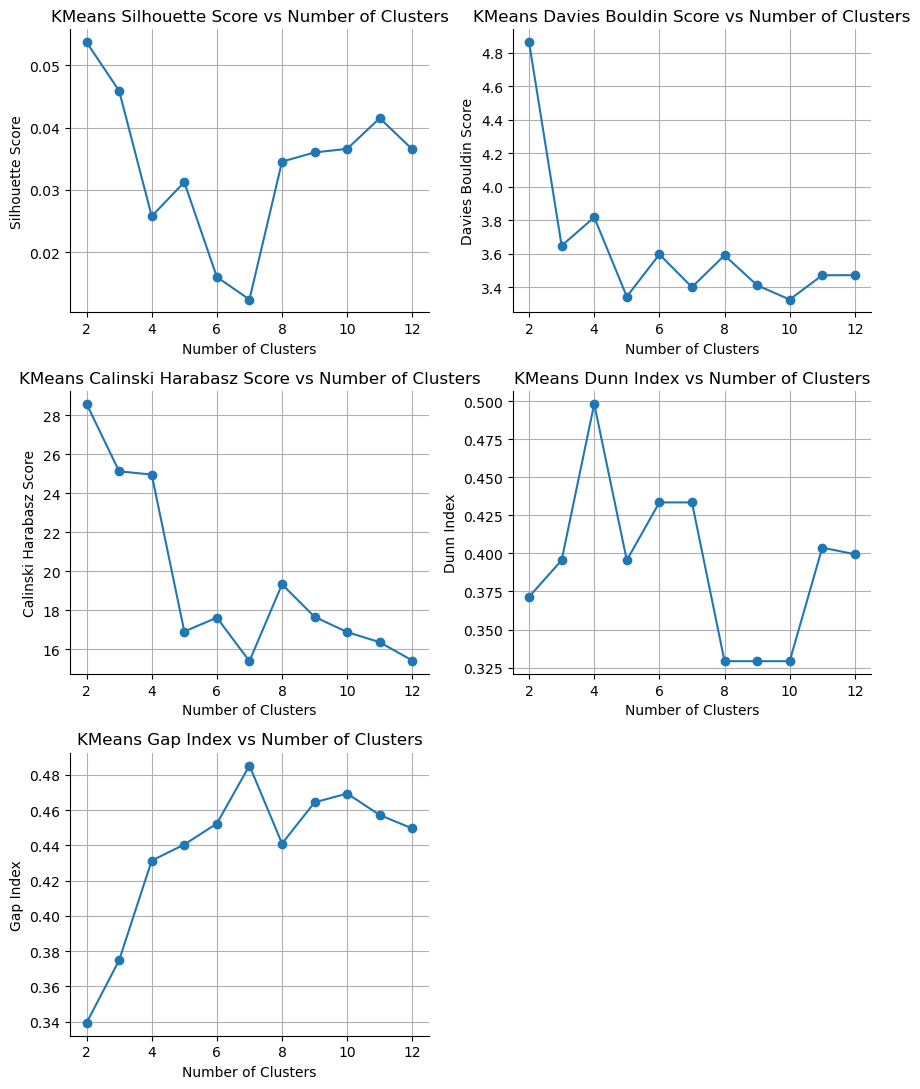

In [10]:
hidden_dim_lst = [64, 22]
input_dim = 88
RNNAE_64_22mir_BothFull = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers=None, seq_len=timesteps, progressive=False, mirror=True)
RNNAE_64_22mir_BothFull.load_state_dict(torch.load(model_dir_path+'RNNAE_64_22mir_vallossp262_BothFull.pth'))

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(RNNAE_64_22mir_BothFull, both_test_loader)

latent_representations = np.concatenate(latent_representations_lst)
latent_representations_reshaped = latent_representations.reshape(latent_representations.shape[0], -1)

km_silhouette_lst=[]
km_davies_bouldin_lst=[]
km_cali_har_lst=[]
km_dunn_index_lst=[]
km_gap_stat_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('KMeans', latent_representations_reshaped, num_clusters=n)
    km_silhouette_lst.append(silhouette)
    km_davies_bouldin_lst.append(db_index)
    km_cali_har_lst.append(ch_index)
    km_dunn_index_lst.append(di_index)
    km_gap_stat_lst.append(gap_stat)

plot_five_clus_metrics(num_clusters_range, km_silhouette_lst, km_davies_bouldin_lst, km_cali_har_lst, km_dunn_index_lst, km_gap_stat_lst)


Average testing loss across the entire test_loader: 0.41911541670560837
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


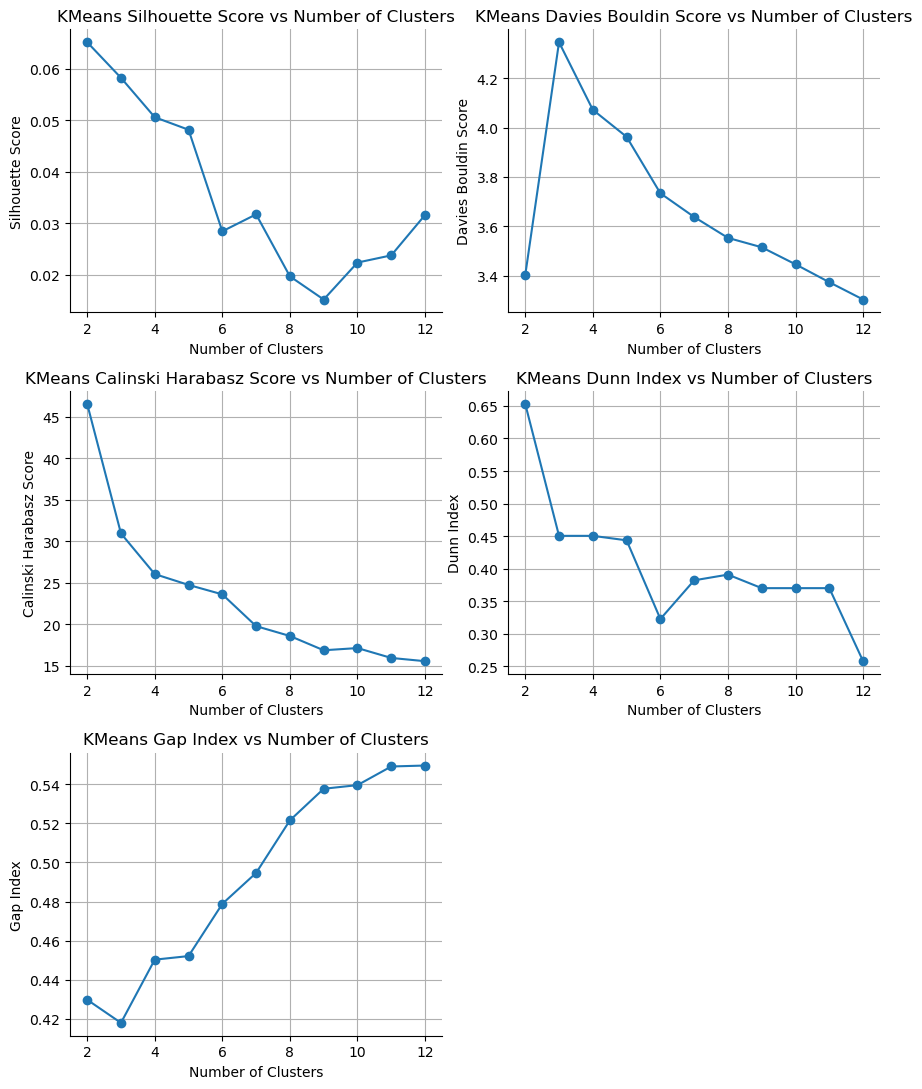

In [11]:
hidden_dim_lst = [56, 28]
input_dim = 40
RNNAE_56_28mir_BothPCA40 = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers=None, seq_len=timesteps, progressive=False, mirror=True)
RNNAE_56_28mir_BothPCA40.load_state_dict(torch.load(model_dir_path+'RNNAE_56_28mir_vallossp419_BothPCA40.pth'))

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(RNNAE_56_28mir_BothPCA40, both_pca_test_loader)

latent_representations = np.concatenate(latent_representations_lst)
latent_representations_reshaped = latent_representations.reshape(latent_representations.shape[0], -1)

km_silhouette_lst=[]
km_davies_bouldin_lst=[]
km_cali_har_lst=[]
km_dunn_index_lst=[]
km_gap_stat_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('KMeans', latent_representations_reshaped, num_clusters=n)
    km_silhouette_lst.append(silhouette)
    km_davies_bouldin_lst.append(db_index)
    km_cali_har_lst.append(ch_index)
    km_dunn_index_lst.append(di_index)
    km_gap_stat_lst.append(gap_stat)

plot_five_clus_metrics(num_clusters_range, km_silhouette_lst, km_davies_bouldin_lst, km_cali_har_lst, km_dunn_index_lst, km_gap_stat_lst)


Average testing loss across the entire test_loader: 0.2774711867625063
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


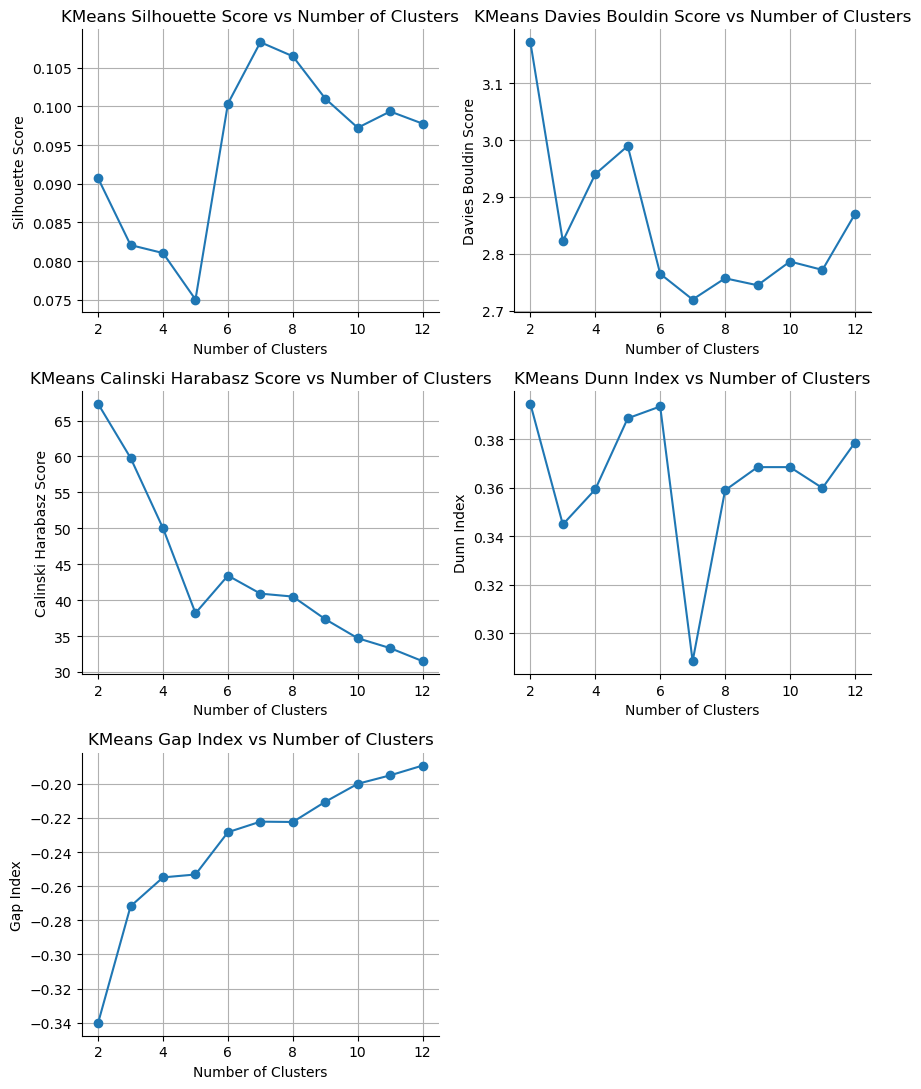

In [12]:
hidden_dim_lst = [9]
input_dim = 16
RNNAE_9mir_EMGFull = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers=None, seq_len=timesteps, progressive=False, mirror=True)
RNNAE_9mir_EMGFull.load_state_dict(torch.load(model_dir_path+'RNNAE_9mir_vallossp277_EMGFull.pth'))

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(RNNAE_9mir_EMGFull, emg_test_loader)

latent_representations = np.concatenate(latent_representations_lst)
latent_representations_reshaped = latent_representations.reshape(latent_representations.shape[0], -1)

km_silhouette_lst=[]
km_davies_bouldin_lst=[]
km_cali_har_lst=[]
km_dunn_index_lst=[]
km_gap_stat_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('KMeans', latent_representations_reshaped, num_clusters=n)
    km_silhouette_lst.append(silhouette)
    km_davies_bouldin_lst.append(db_index)
    km_cali_har_lst.append(ch_index)
    km_dunn_index_lst.append(di_index)
    km_gap_stat_lst.append(gap_stat)

plot_five_clus_metrics(num_clusters_range, km_silhouette_lst, km_davies_bouldin_lst, km_cali_har_lst, km_dunn_index_lst, km_gap_stat_lst)
